In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import glob
from collections import Counter
import os

import tqdm
import optuna
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Функция gc.collect()является встроенной функцией Python, которая собирает и освобождает память, которая больше не используется программой.
import gc
gc.collect()

2083

# Загрузка данных

In [5]:
chosen_features = ['feature_80', 'feature_47', 'feature_421', 'feature_48', 'feature_383', 'feature_424', 'feature_234', 'feature_353', 'feature_244', 'feature_35', 'feature_131', 'feature_11', 'feature_462', 'feature_239', 'feature_98', 'feature_467', 'feature_195', 'feature_100', 'feature_365', 'feature_164', 'feature_166', 'feature_154', 'feature_390', 'feature_230', 'feature_133', 'feature_157', 'feature_439', 'feature_428', 'feature_45', 'feature_332', 'feature_212', 'feature_119', 'feature_153', 'feature_490', 'feature_371', 'feature_81', 'feature_201', 'feature_139', 'feature_452', 'feature_53', 'feature_51', 'feature_42', 'feature_223', 'feature_364', 'feature_197', 'feature_114', 'feature_251', 'feature_87', 'feature_451', 'feature_12', 'feature_470', 'feature_97', 'feature_318', 'feature_325', 'feature_147', 'feature_323', 'feature_86', 'feature_138', 'feature_435', 'feature_68', 'feature_331', 'feature_242', 'feature_495', 'feature_151', 'feature_18', 'feature_412', 'feature_262', 'feature_31', 'feature_481', 'feature_66', 'feature_270', 'feature_129', 'feature_356', 'feature_124', 'feature_168', 'feature_14', 'feature_369', 'feature_336', 'feature_167', 'feature_225', 'feature_152', 'feature_186', 'feature_480', 'feature_273', 'feature_44', 'feature_386', 'feature_265', 'feature_142', 'feature_493', 'feature_209', 'feature_198', 'feature_172', 'feature_194', 'feature_259', 'feature_310', 'feature_341', 'feature_144', 'feature_482', 'feature_5', 'feature_272', 'feature_345', 'feature_411', 'feature_8', 'feature_136', 'feature_314', 'feature_335', 'feature_264', 'feature_161', 'feature_37', 'feature_296', 'feature_334', 'feature_214', 'feature_106', 'feature_175', 'feature_120', 'feature_491', 'feature_231', 'feature_340', 'feature_392', 'feature_246', 'feature_232', 'feature_108', 'feature_148', 'feature_361', 'feature_143', 'feature_204', 'feature_29', 'feature_118', 'feature_460', 'feature_132', 'feature_461', 'feature_205', 'feature_432', 'feature_200', 'feature_253', 'feature_254', 'feature_59', 'feature_170', 'feature_84', 'feature_16', 'feature_137', 'feature_179', 'feature_473', 'feature_449', 'feature_65', 'feature_378', 'feature_427', 'feature_350', 'feature_359', 'feature_283', 'feature_158', 'feature_34', 'feature_149', 'feature_284', 'feature_146', 'feature_408', 'feature_321', 'feature_69', 'feature_444', 'feature_126']
len(chosen_features)

160

In [6]:
len(set(chosen_features))

160

In [7]:
categorial_features = ['feature_17', 'feature_21', 'feature_22', 'feature_27', 'feature_31', 'feature_43', 'feature_61', 'feature_64', 'feature_80', 'feature_83', 'feature_92', 'feature_133', 'feature_143', 'feature_166', 'feature_173', 'feature_191', 'feature_201', 'feature_209', 'feature_251', 'feature_253', 'feature_299', 'feature_300', 'feature_343', 'feature_347', 'feature_382', 'feature_392', 'feature_405', 'feature_406', 'feature_423', 'feature_434', 'feature_446', 'feature_449', 'feature_459', 'feature_490', 'feature_492']

In [8]:
filenames_train = glob.glob(os.path.join('Files/Train', "*.csv"))

def compression(filename, ch_features, features=['target']):
    global data, base_info, transformed_data, result
    data = pd.read_csv(filename)
    base_info = data[features]
    transformed_data = data[ch_features]
    result = pd.concat([base_info, transformed_data], ignore_index=True, axis=1)
    return result


data_files_train = []


for filename in filenames_train:
    data_files_train.append(compression(filename, chosen_features))

In [9]:
# Объединим тренировочные данные в единый датасет
train_data = pd.concat(data_files_train, ignore_index=True)

# Удалим ненужные переменные для очистки памяти
del data_files_train, filenames_train, data, base_info, transformed_data, result

In [10]:
display(train_data.head())

display(train_data.shape)

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,0,0.0,1.105071,-0.991140,-0.510074,1.521255,-0.390544,-0.269228,1.198390,-0.180877,...,-1.568377,0.264994,-0.332432,-0.042886,1.332306,0.410404,0.019665,-0.900065,-0.046334,0.911195
1,0,0.0,1.592504,-0.902399,-0.533821,1.514084,1.405829,-1.114410,-1.026604,-0.310010,...,-0.623915,-1.332586,-0.263667,-1.287814,-0.995214,-2.025086,-0.920974,-1.604311,0.163374,-1.883683
2,0,1.0,-0.077110,1.793526,1.186129,1.683552,1.058887,-0.939500,-0.336486,-0.478118,...,-0.920769,-0.178598,-1.495145,-0.896754,-0.065647,0.147978,-0.075012,0.157078,0.373993,0.597157
3,0,0.0,0.358295,-1.228618,1.201558,1.527639,0.503792,0.819450,0.468487,-0.016058,...,0.583278,-1.591858,-0.137070,-0.285638,-0.160680,0.619756,0.914246,0.470563,-1.092003,-0.291760
4,0,1.0,-0.573284,-0.891564,0.191383,1.389515,-0.112223,0.944984,0.008421,-0.445145,...,0.609685,0.425884,0.372154,-0.533092,-1.205486,-0.249361,1.489491,-1.740211,1.090335,0.562604


(4490468, 161)

In [11]:
train_data.columns = ['target'] + chosen_features
train_data.columns

Index(['target', 'feature_80', 'feature_47', 'feature_421', 'feature_48',
       'feature_383', 'feature_424', 'feature_234', 'feature_353',
       'feature_244',
       ...
       'feature_158', 'feature_34', 'feature_149', 'feature_284',
       'feature_146', 'feature_408', 'feature_321', 'feature_69',
       'feature_444', 'feature_126'],
      dtype='object', length=161)

# Используемые функции

In [12]:
def get_train_val_test_split(df, y_col):
    X = df.drop(columns=[y_col])
    y = df[y_col]
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def feature_importance_func(importance, names, model_name="", top_n=-1, skip_columns=[], plot=False):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    if plot:
        plt.figure(figsize=(12,10))
        sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
        if top_n != -1:
            plt.title(f"{model_name} Feature Importance (Top: {top_n})")
        else:
            plt.title(f"{model_name} Feature Importance")
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
    
    lst_ = list(fi_df['feature_names'][:top_n])
    return lst_, fi_df


def objective(trial):
    params = {
#         "learning_rate": trial.suggest_loguniform('learning_rate', 0.01, 0.04),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 7, 12),
        "depth" : trial.suggest_int("depth", 5, 10),
        "iterations" : trial.suggest_int("iterations", 3500, 4500, 100),
        'random_strength':trial.suggest_float('random_strength', 7, 12),
        'bagging_temperature':trial.suggest_float('bagging_temperature', 0, 1),
    }
    
    catboost_model = CatBoostClassifier(
        loss_function = 'CrossEntropy',
        random_state = 42,
        task_type = 'GPU',
        eval_metric='AUC',
        grow_policy = 'Lossguide',
        verbose = 500,
        cat_features=model_categorial_f,
        **params
    )
    

    catboost_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        plot=False,
        verbose=500
                )
    
    y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

# Разделение на train, val, test

In [13]:
train_data_new = train_data[chosen_features+['target']]

In [14]:
model_categorial_f = list(np.intersect1d(categorial_features, train_data_new.columns))
train_data_new[model_categorial_f] = train_data_new[model_categorial_f].astype(str)

In [15]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_test_split(train_data_new, 'target')

# Обучение моделей catboost

- 1) Обучение 10 моделей с гиперпараметрами best_params_for_subm_23 и разными random_state
- 2) Обчение 5 моделей с гиперпараметрами best_params и разными random_state
- 3) Обчение 2 моделей с гиперпараметрами best_params и разными random_state с количеством объектов, представляющих класс 0 и состовляющих 80% от общего количества объектов класса 0 в тренировочном датасете (аналогично для 60%, 40%, 20%)

In [18]:
best_params_for_subm_23 = {'learning_rate': 0.05, 'l2_leaf_reg': 7, 'depth': 12, 'min_data_in_leaf': 5, 'iterations': 1000}
best_params = {'iterations': 4000, 'depth': 8, 'learning_rate': 0.01760147810912163, 'l2_leaf_reg': 4.66473678711569, 'bagging_temperature': 0.7748072164693346, 'min_data_in_leaf': 1456, 'max_leaves': 3795}

In [20]:
filtered_data_0 = train_data_new[train_data_new['target'] == 0]

sample_size_0 = int(0.6 * len(filtered_data_0))
sampled_data_0 = filtered_data_0.sample(n=sample_size_0, random_state=42)

filtered_data_1 = train_data_new[train_data_new['target'] == 1]
final_data = pd.concat([sampled_data_0, filtered_data_1])

In [21]:
targets = final_data['target']

In [22]:
CatBoostModel = CatBoostClassifier(
        loss_function = 'CrossEntropy',
        random_state = 43,
#         custom_loss = 'AUC',
        eval_metric = 'AUC',
        task_type = 'GPU',
        verbose = 500,
        grow_policy = 'Lossguide',
        use_best_model=True,
        **best_params
    )

CatBoostModel.fit(
#     final_data, targets,
#     X_train, y_train,
    final_data.drop(columns=['target']), targets,
#     train_data_new.drop(columns=['target']), train_data_new['target'],
    eval_set=(X_val, y_val),
    cat_features=model_categorial_f,
#     plot=True,
    verbose=500
            )

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7913456	best: 0.7913456 (0)	total: 513ms	remaining: 34m 10s
500:	test: 0.8697879	best: 0.8697879 (500)	total: 1m 34s	remaining: 11m
1000:	test: 0.8834331	best: 0.8834331 (1000)	total: 2m 54s	remaining: 8m 42s
1500:	test: 0.8929656	best: 0.8929656 (1500)	total: 4m 7s	remaining: 6m 51s
2000:	test: 0.9008936	best: 0.9008936 (2000)	total: 5m 17s	remaining: 5m 17s
2500:	test: 0.9080623	best: 0.9080623 (2500)	total: 6m 27s	remaining: 3m 52s
3000:	test: 0.9150060	best: 0.9150060 (3000)	total: 7m 37s	remaining: 2m 32s
3500:	test: 0.9216058	best: 0.9216058 (3500)	total: 8m 48s	remaining: 1m 15s
3999:	test: 0.9277804	best: 0.9277804 (3999)	total: 10m	remaining: 0us
bestTest = 0.9277804494
bestIteration = 3999


In [23]:
y_pred_proba = CatBoostModel.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

0.9265302028401196


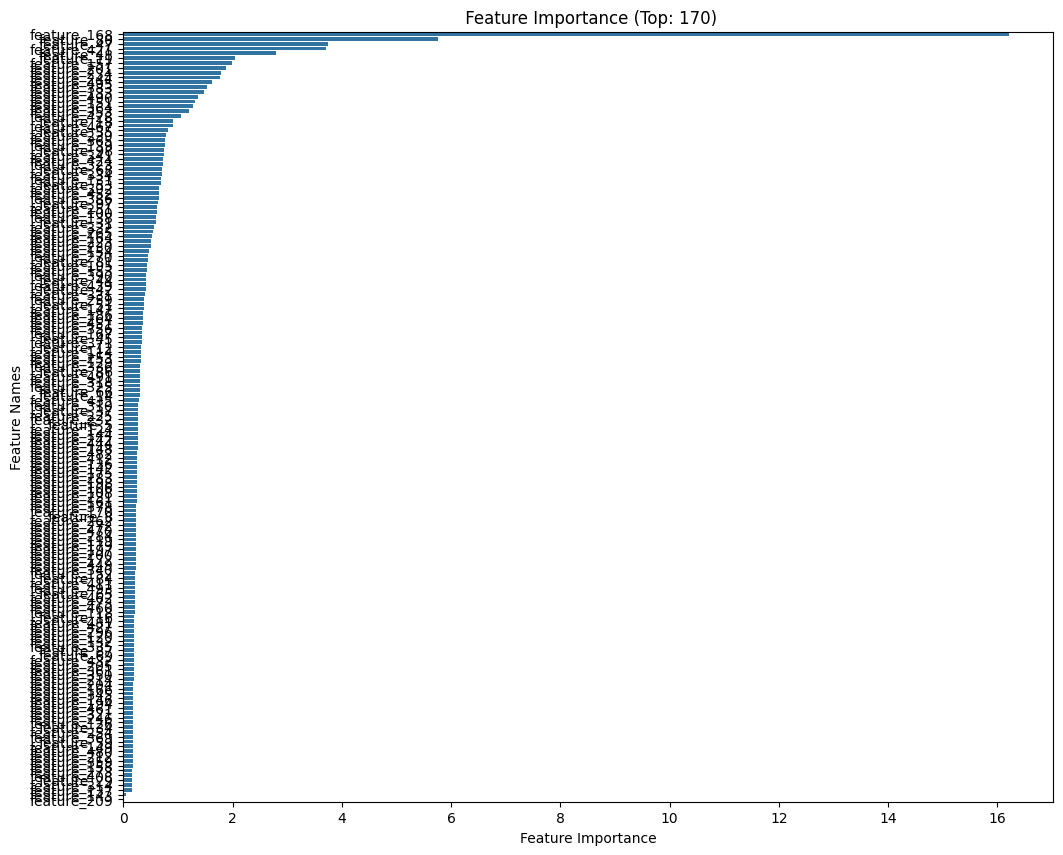

In [82]:
feat_imp, res = feature_importance_func(CatBoostModel.get_feature_importance(), X_test.columns, top_n=170, plot=True)

# Тестовые данные, подготовка сабмитов

In [24]:
csv_files = glob.glob(os.path.join('Files/Test', "*.csv"))

df_list = []

for f in csv_files:
    df = pd.read_csv(f, index_col=None)
    df_list.append(df)

df_test = pd.concat(df_list, ignore_index=True)
df_test.head()

,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499,feature_500
0,test,4490468,0.177531,-1.152211,1.846728,0.008738,-0.431573,-0.263363,-0.224663,-0.333859,...,0.386282,0.0,-0.427527,-0.633689,-0.643390,0.657669,1.647757,1.316002,-0.796995,0.415446
1,test,4490469,0.094399,-0.008647,0.505909,-1.539033,-1.108592,0.649972,-0.186942,1.166843,...,-1.061810,0.0,-0.688414,0.402823,-1.229459,0.816359,1.407067,0.159468,-1.581195,-0.149426
2,test,4490470,1.307947,0.370070,1.139814,-0.535084,0.914847,0.325444,0.806360,0.317192,...,0.452823,1.0,-0.008884,-0.366426,-0.023610,0.248698,0.743751,-2.284203,-0.709692,0.028168
3,test,4490471,0.645874,-1.677962,0.910589,1.057324,-0.107759,-0.145189,-0.418729,-1.128467,...,-1.043129,0.0,1.593004,0.755048,-0.007679,-1.280468,2.135446,-0.491173,-0.774960,0.836896
4,test,4490472,0.075710,0.709553,-1.667854,1.519592,0.016205,0.585399,0.993821,1.755325,...,1.445559,0.0,1.325508,2.607319,1.480621,1.367421,0.783927,0.727547,-0.405008,1.248272


In [25]:
test_data = df_test[X_train.columns]
test_data[model_categorial_f] = test_data[model_categorial_f].astype(str)

In [26]:
len(test_data.columns)

160

In [27]:
# Сохранение результатов
y_test_pred = CatBoostModel.predict_proba(test_data)

y_test_pred = pd.Series(y_test_pred[:, 1])

test_data['target'] = y_test_pred
test_data['id'] = df_test['id']

test_data[['id', 'target']].to_csv('submission_2version_full_06_43.csv', index=False)

# Формирование итогового сабмита

Усреднение прогнозов моделей для уменьшения общей дисперсии

### План составления итогового сабмита

1) Усреднение результатов 10 моделей с best_params_for_subm_23, формирование sumbmission_23
2) Усреднение результатов 5 моделей с best_params, и (2+2+2+2) моделей с разной долей объектов класса 0, формирование submission_full_set_2_mean
3) Усреднение sumbmission_23 и submission_full_set_2_mean

In [ ]:
# 1 часть

sub_1 = pd.read_csv('submission_10.csv', index_col = False)
sub_2 = pd.read_csv('submission_12_for_voting.csv', index_col = False)
sub_3 = pd.read_csv('submission_13_for_voting.csv', index_col = False)
sub_4 = pd.read_csv('submission_15_for_voting.csv', index_col = False)
sub_5 = pd.read_csv('submission_16_for_voting.csv', index_col = False)
sub_6 = pd.read_csv('submission_17_for_voting.csv', index_col = False)
sub_7 = pd.read_csv('submission_18_for_voting.csv', index_col = False)
sub_8 = pd.read_csv('submission_19_for_voting.csv', index_col = False)
sub_9 = pd.read_csv('submission_20_for_voting.csv', index_col = False)
sub_10 = pd.read_csv('submission_22_for_voting.csv', index_col = False)

sub_1['target_2'] = sub_2['target']
sub_1['target_3'] = sub_3['target']
sub_1['target_4'] = sub_4['target']
sub_1['target_5'] = sub_5['target']
sub_1['target_6'] = sub_6['target']
sub_1['target_7'] = sub_7['target']
sub_1['target_8'] = sub_8['target']
sub_1['target_9'] = sub_9['target']
sub_1['target_10'] = sub_10['target']

sub_1['mean'] = sub_1.iloc[:,1:].mean(axis=1)

mean_df = sub_1.drop(columns=sub_1.columns[1:-1]).copy()

mean_df.rename(columns={'mean':'target'}, inplace=True)

mean_df[['id', 'target']].to_csv('submission_23.csv', index=False)

In [ ]:
# 2 часть

sub_1 = pd.read_csv('submission_full_dataset(3)_2set_2params_105states.csv', index_col = False)
sub_2 = pd.read_csv('submission_full_dataset(3)_2set_2params_200states.csv', index_col = False)
sub_3 = pd.read_csv('submission_full_dataset(3)_2set_2params_21states.csv', index_col = False)
sub_4 = pd.read_csv('submission_full_dataset(3)_2set_2params_42states.csv', index_col = False)
sub_5 = pd.read_csv('submission_full_dataset(3)_2set_2params_777states.csv', index_col = False)
sub_6 = pd.read_csv('submission_2version_full_02_42.csv', index_col = False)
sub_7 = pd.read_csv('submission_2version_full_02_43.csv', index_col = False)
sub_8 = pd.read_csv('submission_2version_full_04_42.csv', index_col = False)
sub_9 = pd.read_csv('submission_2version_full_04_43.csv', index_col = False)
sub_10 = pd.read_csv('submission_2version_full_06_42.csv', index_col = False)
sub_11 = pd.read_csv('submission_2version_full_06_43.csv', index_col = False)
sub_12 = pd.read_csv('submission_2version_full_08_42.csv', index_col = False)
sub_13 = pd.read_csv('submission_2version_full_08_43.csv', index_col = False)


sub_1['target_2'] = sub_2['target']
sub_1['target_3'] = sub_3['target']
sub_1['target_4'] = sub_4['target']
sub_1['target_5'] = sub_5['target']
sub_1['target_6'] = sub_6['target']
sub_1['target_7'] = sub_7['target']
sub_1['target_8'] = sub_8['target']
sub_1['target_9'] = sub_9['target']
sub_1['target_10'] = sub_10['target']
sub_1['target_11'] = sub_11['target']
sub_1['target_12'] = sub_12['target']
sub_1['target_13'] = sub_13['target']


sub_1['mean'] = sub_1.iloc[:,1:].mean(axis=1)

mean_df = sub_1.drop(columns=sub_1.columns[1:-1]).copy()
mean_df.rename(columns={'mean':'target'}, inplace=True)
mean_df[['id', 'target']].to_csv('submission_full_set_2_mean.csv', index=False)

In [ ]:
# 3 часть

sub_1 = pd.read_csv('submission_full_set_2_mean.csv', index_col = False)
sub_2 = pd.read_csv('submission_23.csv', index_col = False)

sub_1['target_2'] = sub_2['target']

sub_1['mean'] = sub_1.iloc[:,1:].mean(axis=1)
mean_df = sub_1.drop(columns=sub_1.columns[1:-1]).copy()
mean_df.rename(columns={'mean':'target'}, inplace=True)
mean_df[['id', 'target']].to_csv('submission_66.csv', index=False)

**Итоговый ROC-AUC Score = 86.1735**